In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import os.path
import time, itertools, re
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split,StratifiedGroupKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
print(os.getcwd())
fileloc_data='/'.join(os.getcwd().split('/')[0:5])+ '/data/annonymizedDatasets/'
print(fileloc_data)
savetag='MainDectool'
#sys.path.append('/'.join(os.getcwd().split('/')[0:4])+'/nan_smote/')
from FigPlotting import clusterPlot
#############################################
df_main_full=pd.read_csv(fileloc_data+'maskedDAIsy_MainDectoolEDEQ_Visit1_Only.tsv', sep='\t', decimal=',')
df_Questionnaires=pd.read_csv(fileloc_data+'maskedDAIsy_MainDec_ED_SQ48_MHCSF_Honos_Lav_Visit1.tsv', sep='\t', decimal=',')
intid_Quest=df_Questionnaires['intid'].astype(float).unique()
df_main_full['intid']=df_main_full['intid'].astype(float)

/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling
/home/sreejita/ProjectsPy/GGZ/data/annonymizedDatasets/


In [2]:
colsDectools=['BMI', 'IND_eerdere_spec_behandeling_zonder_effect', 'aantal_eerdere_trajecten', 
    'IND_duur_stoornis_2plus_jaar', 'duur_stoornis_in_jaren', 'IND_as_I_II_comorbiditeiten',
    'IND_depressie_comorbiditeit', 'IND_borderline_comorbiditeit', 'IND_ocd_comorbiditeit', 'IND_anders',
    'IND_ernstig_verstoord_eten']

colNames=['Main-Age', 'Main-BSex','Main-EduLevel', 'Main-ED_Codes', 'EDEQ-score','DT-BMI', 'DT-IND_prev_spec_int_wo_eff', 
'DT-num_prev_routes', 'DT-IND_Disorder_Duration_2+Yrs', 'DT-Disorder_Duration_Yrs', 'DT-IND_I_II_CMD', 'DT-IND_depressie_CMD',
'DT-IND_BDL_CMD', 'DT-IND_OCD_CMD', 'DT-IND_others','DT-IND_VDisturbdEating']  

df_main_full['BMI']=df_main_full['BMI'].astype(float)
df_main_full['duur_stoornis_in_jaren']=df_main_full['duur_stoornis_in_jaren'].astype(float)
df_main_subset=df_main_full.loc[df_main_full['intid'].isin(intid_Quest)].copy()
print(df_main_full.shape, df_main_subset.shape)
print(df_main_full['intid'].nunique(), df_main_subset['intid'].nunique())
print(df_main_full['pid'].nunique(), df_main_subset['pid'].nunique())
###############################################################################################
df_train_explore=df_main_full.loc[df_main_full['Split']=='Train']
print(df_train_explore['bsex'].value_counts())
print(df_train_explore['EDtype'].value_counts())
df_train_explore['bsex'] = df_train_explore['bsex'].astype('category')
df_train_explore['biosex'] = df_train_explore['bsex'].cat.codes
df_train_explore['biosex']=df_train_explore['biosex'].astype(float)
df_train_explore['EDtype'] = df_train_explore['EDtype'].astype('category')
df_train_explore['ED_Codes'] = df_train_explore['EDtype'].cat.codes
df_train_explore['Highest_Edu'] = df_train_explore['Highest_Edu'].astype('category')
df_train_explore['Edu_codes'] = df_train_explore['Highest_Edu'].cat.codes
df_train_explore['Edu_codes']=df_train_explore['Edu_codes'].astype(float)
cols2consider=['age','biosex', 'Edu_codes','ED_Codes', 'EDEQscore']+colsDectools

(300, 35) (138, 35)
300 138
298 138
bsex
Vrouw    215
Man       10
Name: count, dtype: int64
EDtype
Anorexia nervosa    88
Bulimia nervosa     40
Binge-ED            38
Other ED            38
Others              21
Name: count, dtype: int64


### Visualizing Missing Values

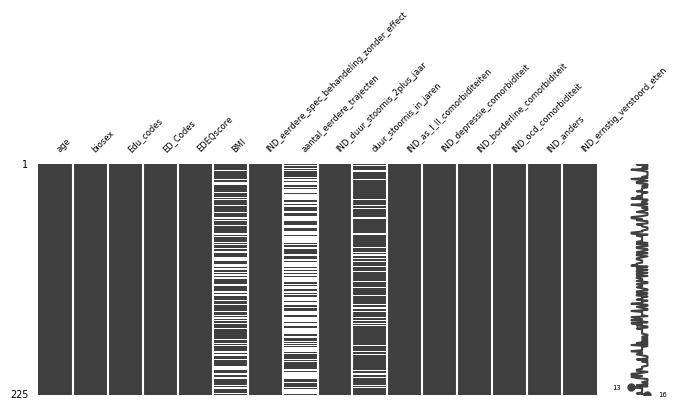

In [3]:
#!pip install missingno
import missingno as msno 
fig = msno.matrix(df_train_explore[cols2consider],figsize=(8, 3), fontsize=6)
grid_ax = fig.axes
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_NaNPatterns.pdf'%savetag)
plt.savefig('figs/PNGs/ED_%s_NaNPatterns.png'%savetag)

#### Eigenvalue decomposition to PCA
#### PPCA

##### EVD of data $X$: steps:
1. Center $X$: $X_c= X-\hat{X}$
2. Covariance of $X_c$: $C=X_c^{T}X_c$ (This also ensures )
3. Eigenvalue decomposition of Covariance of $X_c$: $eigVal, eigVec=eig(C) $

In [4]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import pairwise_distances
from numpy.linalg import norm
from sklearn import metrics
cols2train=['age','biosex', 'ED_Codes']+colsDectools
df_train_explore['aantal_eerdere_trajecten']=df_train_explore['aantal_eerdere_trajecten'].astype(float)
#cols2train=np.setdiff1d(cols2consider,['EDEQscore','ED_Codes'])
#zero_df_train=df_train_explore[cols2train].fillna(0)
labels_true=df_train_explore['ED_Codes']#df_Questionnaires['EDtype'].loc[df_Questionnaires['Split']=='Train']
nan_mean=np.nanmean(df_train_explore[cols2train].to_numpy(), axis=1)
nan_std=np.nanstd(df_train_explore[cols2train].to_numpy(), axis=1)
z_train_explore=((df_train_explore[cols2train].to_numpy().T-nan_mean)/nan_std).T
mask=~np.isnan(z_train_explore)
maskedarr = np.ma.array(z_train_explore, mask=~mask)
eig_val, eig_vec=np.linalg.eig(np.ma.dot(maskedarr.T, maskedarr, mask).data)
sind_eig_val=np.argsort(-1*(eig_val/np.sum(eig_val)))
evd_z_train_explore=np.ma.dot(maskedarr,eig_vec[sind_eig_val[:3]].T, mask)
evd_pdist_cos=pairwise_distances(evd_z_train_explore, metric='cosine')
evd_af = AffinityPropagation(random_state=42, affinity='precomputed',max_iter=100, convergence_iter=20).fit(-1*evd_pdist_cos)
evd_cluster_centers_indices, evd_labels = evd_af.cluster_centers_indices_, evd_af.labels_
evd_n_clusters_ = len(evd_cluster_centers_indices)
print("Estimated number of clusters: %d" % evd_n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, evd_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, evd_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, evd_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, evd_labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, evd_labels))
np.fill_diagonal(evd_pdist_cos, 0)
z_df_train_explore=pd.DataFrame(z_train_explore, columns=cols2train)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(evd_pdist_cos, evd_labels, metric="precomputed"))

Estimated number of clusters: 9
Homogeneity: 0.122
Completeness: 0.092
V-measure: 0.105
Adjusted Rand Index: 0.022
Adjusted Mutual Information: 0.062
Silhouette Coefficient: 0.637


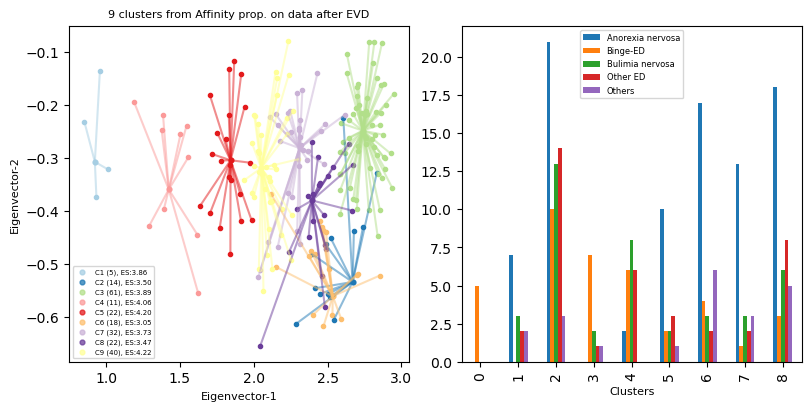

In [5]:
cluster_model={'model': evd_af, 'name': 'Affinity', 'pred_labels': evd_labels,
               'cluster_center_indices':evd_cluster_centers_indices}
data_tabs={'data_to_cluster': evd_pdist_cos, 'data_to_plot': evd_z_train_explore,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['EVD_AP_Clustering', 'MainDectool']
fig_lab_titles={'fig_title': 'clusters from Affinity prop. on data after EVD', 'ncols':1,
               'fs': 8, 'legend_loc': 'lower left', 'ax0_xlab':'Eigenvector-1', 'ax0_ylab':'Eigenvector-2'}
zs_evd_ed_cluster_df, ed_evd_af_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

In [6]:
#!pip install ppca
from ppca import PPCA
ppca = PPCA()
ppca.fit(data=z_train_explore, d=3, verbose=False)
variance_explained, components, model_params  = ppca.var_exp, ppca.data, ppca.C
component_mat = ppca.transform()
ppca_pdist_cos=pairwise_distances(component_mat, metric='cosine')
ppca_af = AffinityPropagation(random_state=42, affinity='precomputed',max_iter=100, convergence_iter=20).fit(-1*ppca_pdist_cos)
ppca_cluster_centers_indices, ppca_labels = ppca_af.cluster_centers_indices_, ppca_af.labels_
ppca_n_clusters_ = len(ppca_cluster_centers_indices)
print("Estimated number of clusters: %d" % ppca_n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, ppca_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, ppca_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, ppca_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, ppca_labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, ppca_labels))
np.fill_diagonal(ppca_pdist_cos, 0)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(ppca_pdist_cos, ppca_labels, metric="precomputed"))

Estimated number of clusters: 12
Homogeneity: 0.420
Completeness: 0.258
V-measure: 0.320
Adjusted Rand Index: 0.136
Adjusted Mutual Information: 0.280
Silhouette Coefficient: 0.590


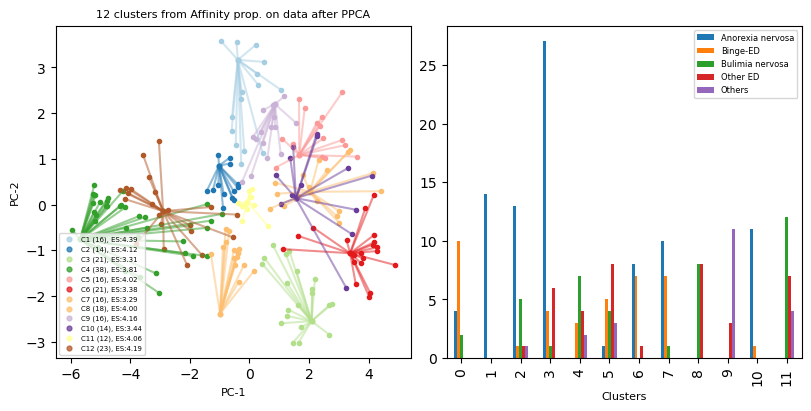

In [7]:
cluster_model={'model': ppca_af, 'name': 'Affinity', 'pred_labels': ppca_labels,
               'cluster_center_indices':ppca_cluster_centers_indices}
data_tabs={'data_to_cluster': ppca_pdist_cos, 'data_to_plot': component_mat,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['PPCA_AP_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from Affinity prop. on data after PPCA', 'ncols':1,
               'fs': 8, 'legend_loc': 'lower left', 'ax0_xlab':'PC-1', 'ax0_ylab':'PC-2'}
zs_ppca_ed_cluster_df, ed_ppca_af_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

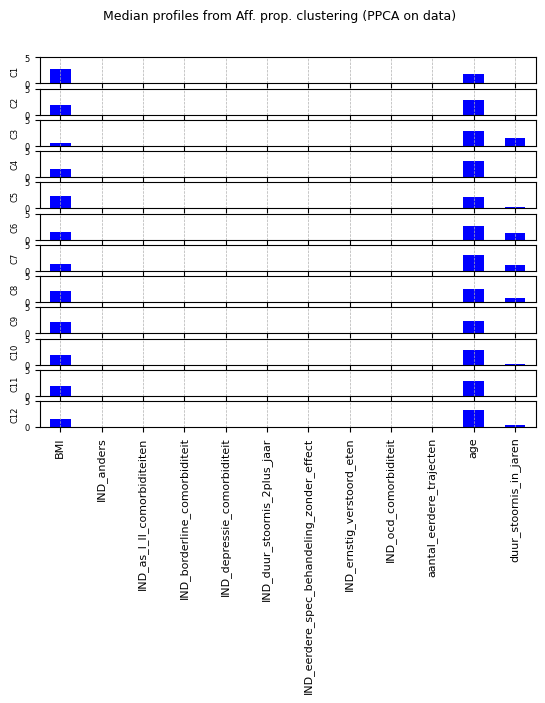

In [8]:
fig41, ax41 = plt.subplots(nrows=ppca_n_clusters_, ncols=1)
colnames=np.setdiff1d(zs_ppca_ed_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])
for nrow in range(0,ppca_n_clusters_):
    df_temp=zs_ppca_ed_cluster_df[colnames].iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=ax41[nrow])
    ax41[nrow].set_ylim(0, 5)
    ax41[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax41[nrow].set_yticklabels(ax41[nrow].get_yticklabels(), fontsize=6)
    if nrow<ppca_n_clusters_-1:        
        ax41[nrow].set_xticklabels('')
    else:
        ax41[nrow].set_xticklabels(colnames, fontsize=8)    
    ax41[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig41.suptitle('Median profiles from Aff. prop. clustering (PPCA on data)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/PDFs/ED_MainDectoolDatasets_PPCA_AP_Profiles.pdf')
plt.savefig('figs/PNGs/ED_MainDectoolDatasets_PPCA_AP_Profiles.png')

#### Trying Affinity Propagation without any dimensionality reduction (i.e., without EVD or PPCA)

In [9]:
pdist_cos = np.zeros((np.shape(z_train_explore)[0],np.shape(z_train_explore)[0]))
for i in range(np.shape(z_train_explore)[0]):
    for j in range(np.shape(z_train_explore)[0]):
        combo_mask=mask[i]& mask[j]
        temp_i, temp_j=z_train_explore[i], z_train_explore[j]
        c_tmp = np.dot(temp_i[combo_mask], temp_j[combo_mask])/(norm(temp_i[combo_mask])*norm(temp_j[combo_mask])) 
        pdist_cos[i][j] = c_tmp
af = AffinityPropagation(random_state=42, affinity='precomputed',max_iter=500, convergence_iter=20).fit(-1*pdist_cos)
cluster_centers_indices, labels, n_clusters_ = af.cluster_centers_indices_, af.labels_, len(af.cluster_centers_indices_)
print("Estimated number of clusters: %d" % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, labels))
np.fill_diagonal(pdist_cos, 0)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(pdist_cos, labels, metric="precomputed"))

Estimated number of clusters: 4
Homogeneity: 0.066
Completeness: 0.072
V-measure: 0.069
Adjusted Rand Index: 0.055
Adjusted Mutual Information: 0.051
Silhouette Coefficient: -0.086


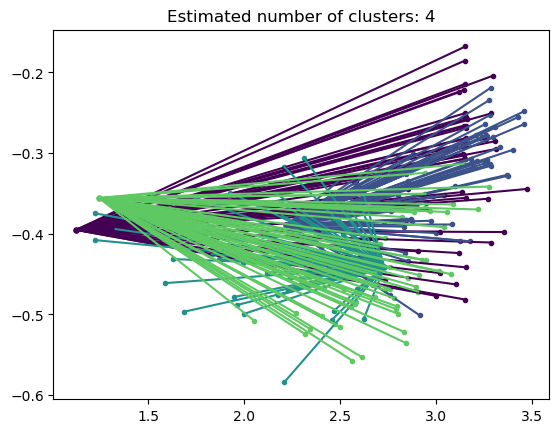

In [10]:
plt.figure(0)
colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, n_clusters_+1)))
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = z_train_explore[cluster_centers_indices[k]]
    cluster_center=cluster_center[mask[cluster_centers_indices[k]]]
    plt.scatter(z_train_explore[class_members, 0], z_train_explore[class_members, 1], 
                color=col["color"], marker=".")
    plt.scatter(cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o")
    for x in z_train_explore[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"])
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

#### Clustering with Gaussian Mixture models

In [51]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

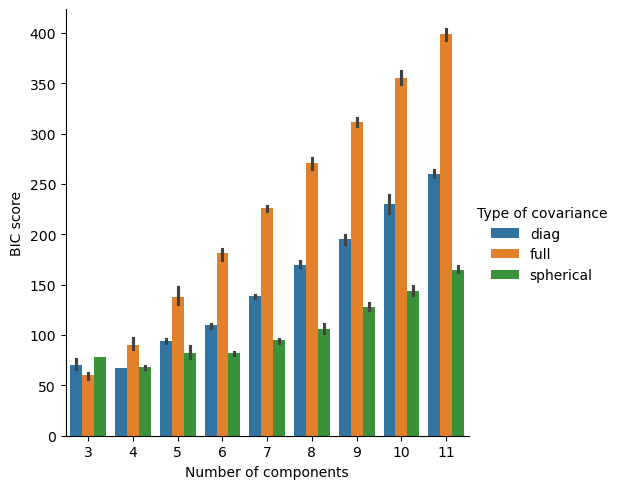

,Number of components,Type of covariance,Init params,BIC score
27,3,full,kmeans,56.619081
45,3,full,random_from_data,62.463147
36,3,full,k-means++,62.609570
73,4,spherical,random_from_data,65.899310
9,3,diag,k-means++,66.063531


In [52]:
param_grid = {"n_components": range(3, 12),
    "covariance_type": ["diag", "full", "spherical"],
    "init_params":['kmeans','k-means++', 'random_from_data']}
grid_search = GridSearchCV(GaussianMixture(n_init=20, max_iter=300), param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(evd_z_train_explore.data)
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type","param_init_params", "mean_test_score", ]]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(columns={"param_n_components": "Number of components",
"param_covariance_type": "Type of covariance", "param_init_params": "Init params", "mean_test_score": "BIC score"})
sns.catplot(data=df, kind="bar", x="Number of components", y="BIC score", hue="Type of covariance",)
plt.show()
df.sort_values(by=["BIC score"]).head()

In [11]:
iters, n_components, data_to_cluster=5, 3, evd_z_train_explore.data
sill=np.zeros(iters,)
for iter in range(0,iters):
    evd_gmm_model_try=GaussianMixture(n_init=20, max_iter=300, n_components=n_components, covariance_type='spherical', 
                          init_params='kmeans').fit(data_to_cluster)
    sill[iter]=metrics.silhouette_score(data_to_cluster, evd_gmm_model_try.predict(data_to_cluster), metric="cosine")
    
print("Average silhouette Coefficient: %0.3f (%.3f)"%(np.mean(sill), np.std(sill)) )

evd_gmm_model=GaussianMixture(n_init=20, max_iter=300, n_components=n_components, covariance_type='spherical', 
                          init_params='k-means++', random_state=11).fit(data_to_cluster)
evd_gmm_labels=evd_gmm_model.predict(data_to_cluster)
evd_gmm_ED_cluster=df_train_explore[['EDtype', 'EDEQscore']].copy()
evd_gmm_ED_cluster['GMMcluster']=evd_gmm_labels

Average silhouette Coefficient: 0.771 (0.000)


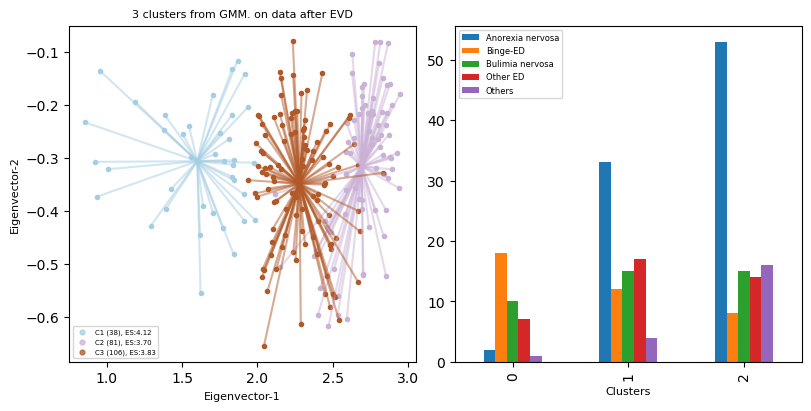

In [12]:
cluster_model={'model': evd_gmm_model, 'name': 'GMM', 'pred_labels': evd_gmm_labels}
data_tabs={'data_to_cluster':evd_z_train_explore.data, 'data_to_plot': evd_z_train_explore.data,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['EVD_GMM_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from GMM. on data after EVD', 'ncols':1,
               'fs': 8, 'legend_loc': 'lower left', 'ax0_xlab':'Eigenvector-1', 'ax0_ylab':'Eigenvector-2'}
zs_evd_gmm_ed_cluster_df, ed_evd_gmm_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

#### Prepresentative profiles of each cluster

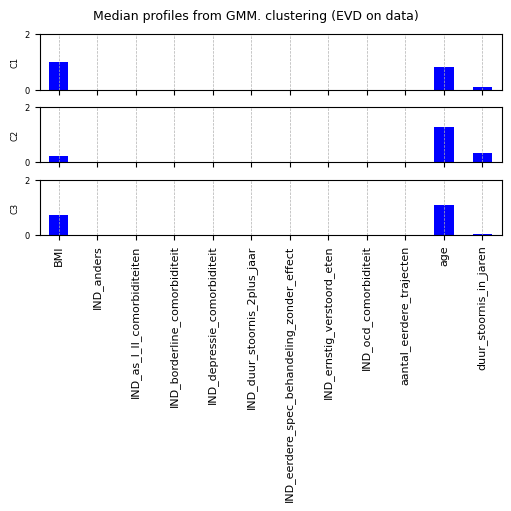

In [13]:
fig51, ax51 = plt.subplots(nrows=n_components, ncols=1, figsize=(5,5), layout='constrained')
colnames=np.setdiff1d(zs_evd_gmm_ed_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])
for nrow in range(0,n_components):
    df_temp=zs_evd_gmm_ed_cluster_df[colnames].iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=ax51[nrow])
    ax51[nrow].set_ylim(0, 5)
    ax51[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax51[nrow].set_yticklabels(ax51[nrow].get_yticklabels(), fontsize=6)
    if nrow<n_components-1:        
        ax51[nrow].set_xticklabels('')
    else:
        ax51[nrow].set_xticklabels(colnames, fontsize=8)    
    ax51[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig51.suptitle('Median profiles from GMM. clustering (EVD on data)', fontsize=9)
plt.savefig('figs/PDFs/ED_MainDectoolDatasets_EVD_GMM_Profiles.pdf')
plt.savefig('figs/PNGs/ED_MainDectoolDatasets_EVD_GMM_Profiles.png')

In [26]:
param_grid2 = {"n_components": range(3, 12),
    "covariance_type": ["diag", "full", "spherical"],
    "init_params":['kmeans','k-means++', 'random_from_data']}
grid_search2 = GridSearchCV(GaussianMixture(n_init=3, max_iter=300), param_grid=param_grid2, scoring=gmm_bic_score)
grid_search2.fit(component_mat)
df2 = pd.DataFrame(grid_search2.cv_results_)[
    ["param_n_components", "param_covariance_type","param_init_params", "mean_test_score", ]]
df2["mean_test_score"] = -df2["mean_test_score"]
df2 = df2.rename(columns={"param_n_components": "Number of components",
"param_covariance_type": "Type of covariance", "param_init_params": "Init params", "mean_test_score": "BIC score"})
df2.sort_values(by=["BIC score"]).head()

,Number of components,Type of covariance,Init params,BIC score
72,3,spherical,random_from_data,543.476146
54,3,spherical,kmeans,544.918178
63,3,spherical,k-means++,547.216645
64,4,spherical,k-means++,552.980799
0,3,diag,kmeans,554.509507


In [19]:
n_components, data_to_cluster=3, component_mat
sill=np.zeros(iters,)
for iter in range(0,iters):
    ppca_gmm_model_try=GaussianMixture(n_init=5, max_iter=300, n_components=3, covariance_type='spherical', 
                          init_params='random_from_data').fit(data_to_cluster)
    sill[iter]=metrics.silhouette_score(data_to_cluster, ppca_gmm_model_try.predict(data_to_cluster), metric="cosine")
print("Average silhouette Coefficient: %0.3f (%.3f)"%(np.mean(sill), np.std(sill)) )

ppca_gmm_model=GaussianMixture(n_init=5, max_iter=300, n_components=n_components, covariance_type='spherical', 
                          init_params='random_from_data', random_state=11).fit(data_to_cluster)
ppca_gmm_labels=ppca_gmm_model.predict(data_to_cluster)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data_to_cluster, ppca_gmm_labels, metric="cosine"))


Average silhouette Coefficient: 0.361 (0.066)
Silhouette Coefficient: 0.420


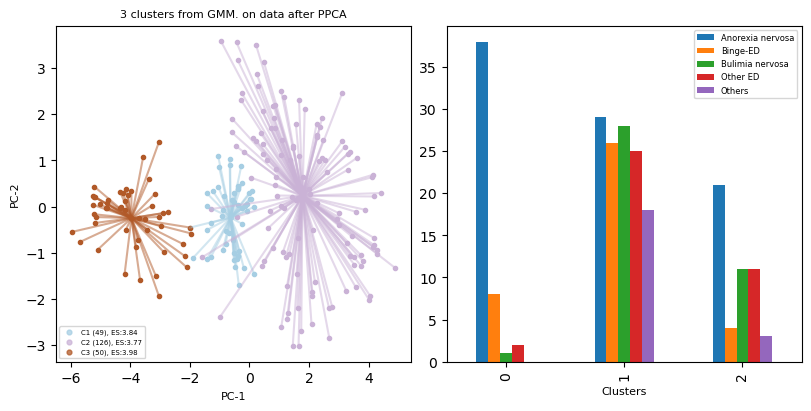

In [20]:
cluster_model={'model': ppca_gmm_model, 'name': 'GMM', 'pred_labels': ppca_gmm_labels}
data_tabs={'data_to_cluster':component_mat, 'data_to_plot': component_mat,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['PPCA_GMM_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from GMM. on data after PPCA', 'ncols':1,
               'fs': 8, 'legend_loc': 'lower left', 'ax0_xlab':'PC-1', 'ax0_ylab':'PC-2'}
zs_ppca_gmm_ed_cluster_df, ed_ppca_gmm_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

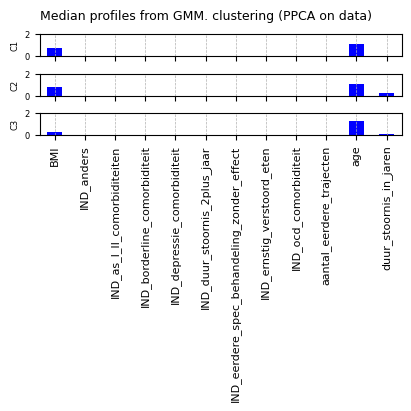

In [23]:
fig61, ax61 = plt.subplots(nrows=n_components, ncols=1, figsize=(4,4), layout='constrained')
colnames=np.setdiff1d(zs_ppca_gmm_ed_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])
for nrow in range(0,n_components):
    df_temp=zs_ppca_gmm_ed_cluster_df[colnames].iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=ax61[nrow])
    ax61[nrow].set_ylim(0, 5)
    ax61[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax61[nrow].set_yticklabels(ax61[nrow].get_yticklabels(), fontsize=6)
    if nrow<n_components-1:        
        ax61[nrow].set_xticklabels('')
    else:
        ax61[nrow].set_xticklabels(colnames, fontsize=8)    
    ax61[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig61.suptitle('Median profiles from GMM. clustering (PPCA on data)', fontsize=9)
plt.savefig('figs/PDFs/ED_MainDectoolDatasets_PPCA_GMM_Profiles.pdf')
plt.savefig('figs/PNGs/ED_MainDectoolDatasets_PPCA_GMM_Profiles.png')

#### Agglomerative clustering

In [25]:
from sklearn.cluster import AgglomerativeClustering
data_to_cluster=ppca_pdist_cos
sill_coef=np.zeros((5,11))
for idx,n_comp in enumerate(range(2,12)):
    for iter in range(0,5):
        try_agg_clust=AgglomerativeClustering(n_clusters=n_comp, affinity='precomputed', linkage='complete').fit(data_to_cluster)
        sill_coef[iter, idx]=metrics.silhouette_score(data_to_cluster,try_agg_clust.fit_predict(data_to_cluster), metric="precomputed")
    print("Silhouette Coefficient of %d clusters: %0.3f (%0.3f)"%(n_comp, np.mean(sill_coef[:,idx]), np.std(sill_coef[:,idx])))

ncomp=np.argsort(-1*np.mean(sill_coef,axis=0))[0]+2
agg_clust=AgglomerativeClustering(n_clusters=ncomp, affinity='precomputed', linkage='complete').fit(data_to_cluster)
agg_labels=agg_clust.fit_predict(data_to_cluster)

Silhouette Coefficient of 2 clusters: 0.553 (0.000)
Silhouette Coefficient of 3 clusters: 0.479 (0.000)
Silhouette Coefficient of 4 clusters: 0.558 (0.000)
Silhouette Coefficient of 5 clusters: 0.525 (0.000)
Silhouette Coefficient of 6 clusters: 0.463 (0.000)
Silhouette Coefficient of 7 clusters: 0.408 (0.000)
Silhouette Coefficient of 8 clusters: 0.378 (0.000)
Silhouette Coefficient of 9 clusters: 0.449 (0.000)
Silhouette Coefficient of 10 clusters: 0.457 (0.000)
Silhouette Coefficient of 11 clusters: 0.510 (0.000)


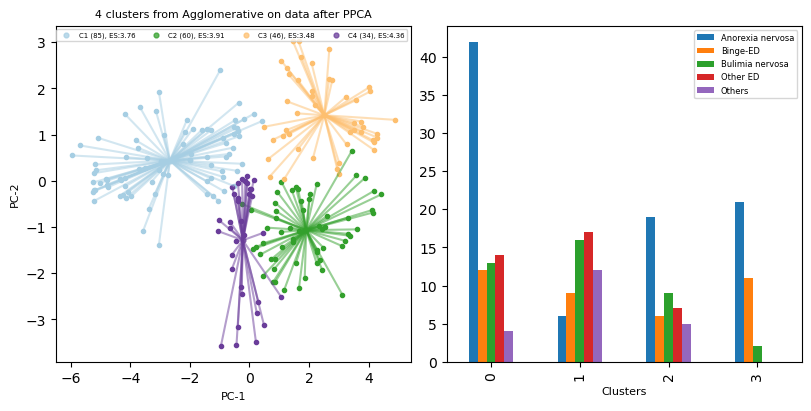

In [28]:
cluster_model={'model': agg_clust, 'name': 'Agglomerative', 'pred_labels':agg_labels}
data_tabs={'data_to_cluster':ppca_pdist_cos, 'data_to_plot': component_mat,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['PPCA_Agglom_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from Agglomerative on data after PPCA', 'ncols':4,
               'fs': 8, 'legend_loc': 'upper right', 'ax0_xlab':'PC-1', 'ax0_ylab':'PC-2'}
zs_ppca_agg_ed_cluster_df, ed_ppca_agg_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

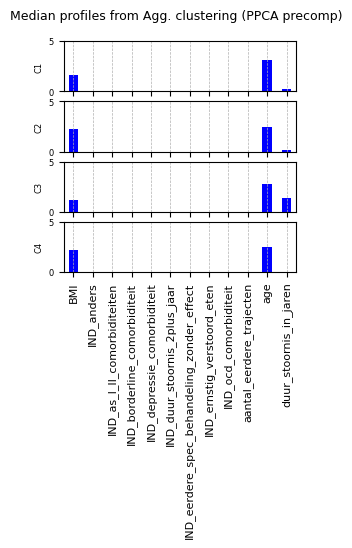

In [35]:
fig8, axes8 = plt.subplots(nrows=ncomp, ncols=1, figsize=(3,3), layout='constrained')
colnames=np.setdiff1d(zs_ppca_agg_ed_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])
for nrow in range(0,ncomp):
    df_temp=zs_ppca_agg_ed_cluster_df[colnames].iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=axes8[nrow])
    axes8[nrow].set_ylim(0, 5)
    axes8[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    axes8[nrow].set_yticklabels(axes8[nrow].get_yticklabels(), fontsize=6)
    if nrow<ncomp-1:        
        axes8[nrow].set_xticklabels('')
    else:
        axes8[nrow].set_xticklabels(colnames, fontsize=8)    
    axes8[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig8.suptitle('Median profiles from Agg. clustering (PPCA precomp)', fontsize=9)
plt.savefig('figs/PDFs/ED_MainDectoolDatasets_PMM_Agg_Clust_Profiles.pdf')
plt.savefig('figs/PNGs/ED_MainDectoolDatasets_PMM_Agg_Clust_Profiles.png')
    #agg_cluster_df[np.setdiff1d(agg_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])].loc[
    #agg_cluster_df['Cluster']==nrow+1].plot(ax=axes8[nrow], kind='bar')